<a href="https://colab.research.google.com/github/3lson/ImageHistogramEqualisation-GPU-/blob/main/ImageHistogramEqualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Histogram Equalization

In [ ]:
!pip install opencv-python
!pip install opencv-python-headless
!pip install Pillow
!pip install cupy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 58.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for cupy
  Running setup.py clean for cupy
Failed to build cupy
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (cupy)


## Imports and Setup

In [2]:
# Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
from google.colab import files
import os
from PIL import Image
import cupy as cp

## Load and Display Image

Saving LowConstrast.jpg to LowConstrast.jpg
Uploaded files:
LowConstrast.jpg
Loading image: LowConstrast.jpg
Size of 'LowConstrast.jpg': 5084 bytes
File path: /content/LowConstrast.jpg
Renamed 'LowConstrast.jpg' to 'Landscape.jpg'.
Detected file type: webp


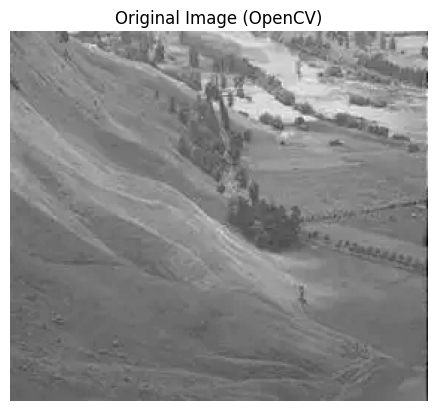

In [3]:
# Step 1: Import necessary libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files  # For uploading files
import os  # For checking file properties
from PIL import Image  # For loading images

# Step 2: Upload the image file
uploaded = files.upload()

# Step 3: Display the names of uploaded files
print("Uploaded files:")
for file_name in uploaded.keys():
    print(file_name)


image_name = next(iter(uploaded))
print(f"Loading image: {image_name}")


file_size = os.path.getsize(image_name)
print(f"Size of '{image_name}': {file_size} bytes")
print(f"File path: /content/{image_name}")


new_name = 'Landscape.jpg'
os.rename(f'/content/{image_name}', f'/content/{new_name}')
print(f"Renamed '{image_name}' to '{new_name}'.")

import imghdr
file_type = imghdr.what(new_name)
print(f"Detected file type: {file_type}")


image_cv = cv2.imread(new_name, cv2.IMREAD_GRAYSCALE)

# Step 5: Check if the image was loaded correctly
if image_cv is None:
    print("Error: Could not load image with OpenCV. Attempting to load with PIL.")

    try:
        image_pil = Image.open(new_name).convert('L')
        plt.imshow(image_pil, cmap='gray')
        plt.title('Original Image (PIL)')
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Error loading image with PIL: {e}")
else:
    # Step 6: Display the original image
    plt.imshow(image_cv, cmap='gray')
    plt.title('Original Image (OpenCV)')
    plt.axis('off')
    plt.show()


## CPU Implementation of Histogram Equalization

In [22]:
def histogram_equalization_cpu(image):
    # Calculate histogram
    hist, _ = np.histogram(image.flatten(), 256, [0, 256])

    # Normalize the histogram
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max() / cdf.max()  # Normalize to max value
    cdf_mapped = np.floor(255 * (cdf / cdf[-1])).astype(np.uint8)  # Map to 0-255 range

    # Use the mapping to create the equalized image
    equalized_image = cdf_mapped[image]
    return equalized_image


## CUDA Kernel for Histogram Calculation


In [23]:
# Step 8: Define the histogram equalization function for GPU
def histogram_equalization_gpu(image):
    # Transfer image to GPU
    image_gpu = cp.asarray(image)

    # Calculate histogram on GPU
    hist_gpu = cp.histogram(image_gpu.flatten(), 256, [0, 256])[0]

    # Normalize the histogram
    cdf_gpu = cp.cumsum(hist_gpu)
    cdf_normalized_gpu = cdf_gpu * hist_gpu.max() / cdf_gpu.max()
    cdf_mapped_gpu = cp.floor(255 * (cdf_gpu / cdf_gpu[-1])).astype(cp.uint8)

    # Use the mapping to create the equalized image on GPU
    equalized_image_gpu = cdf_mapped_gpu[image_gpu]
    return cp.asnumpy(equalized_image_gpu)

In [24]:
import time

# Measure CPU processing time
start_time = time.time()
equalized_image_cpu = histogram_equalization_cpu(image_cv)
cpu_time = time.time() - start_time
print(f"CPU Processing Time: {cpu_time:.6f} seconds")

# Measure GPU processing time
start_time = time.time()
equalized_image_gpu = histogram_equalization_gpu(image_cv)
gpu_time = time.time() - start_time
print(f"GPU Processing Time: {gpu_time:.6f} seconds")


CPU Processing Time: 0.003163 seconds
GPU Processing Time: 0.001729 seconds


## CUDA Kernel for Histogram Equalization

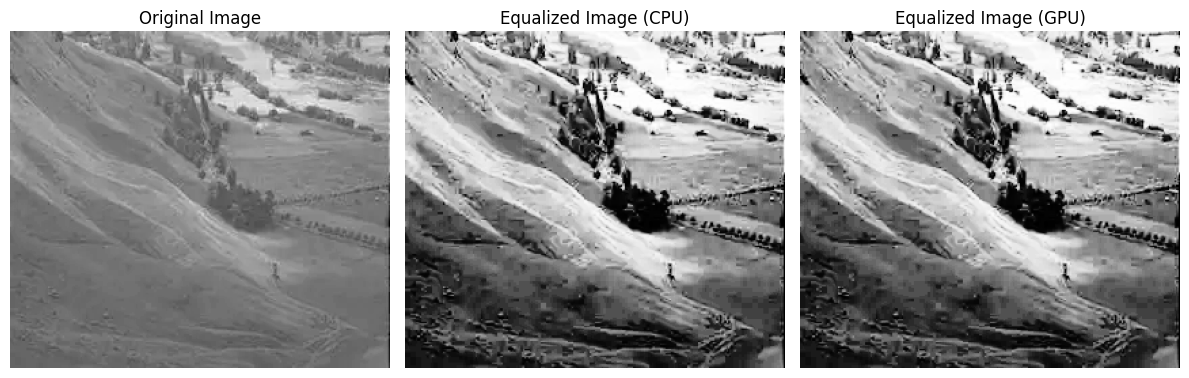

In [15]:
# Step 9: Apply Histogram Equalization
equalized_image_cpu = histogram_equalization_cpu(image_cv)

# Apply GPU Histogram Equalization
equalized_image_gpu = histogram_equalization_gpu(image_cv)

# Step 10: Display the original and equalized images
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image_cv, cmap='gray')
plt.title('Original Image')
plt.axis('off')

# CPU Equalized Image
plt.subplot(1, 3, 2)
plt.imshow(equalized_image_cpu, cmap='gray')
plt.title('Equalized Image (CPU)')
plt.axis('off')

# GPU Equalized Image
plt.subplot(1, 3, 3)
plt.imshow(equalized_image_gpu, cmap='gray')
plt.title('Equalized Image (GPU)')
plt.axis('off')

plt.tight_layout()
plt.show()

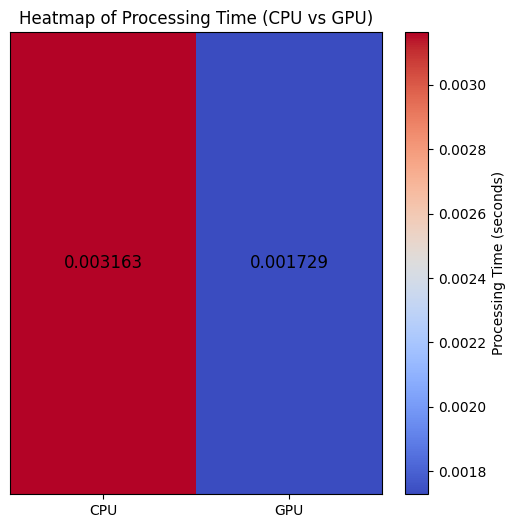

In [26]:
times = np.array([[cpu_time, gpu_time]])

# Plotting the heatmap
plt.figure(figsize=(6, 6))

# Use a diverging colormap (coolwarm) or reversed hot (hot_r) for contrast
plt.imshow(times, cmap='coolwarm', interpolation='nearest', aspect='auto')

# Add a colorbar to indicate the range of processing times
plt.colorbar(label='Processing Time (seconds)')

# Add the actual values on the heatmap
for i in range(times.shape[0]):
    for j in range(times.shape[1]):
        plt.text(j, i, f'{times[i, j]:.6f}', ha='center', va='center', color='black', fontsize=12)

# Adding labels and title
plt.title('Heatmap of Processing Time (CPU vs GPU)')
plt.xticks([0, 1], ['CPU', 'GPU'])  # Label the x-axis
plt.yticks([])  # Remove y-axis labels (no need for row labels)

# Display the heatmap
plt.show()

**CPU (Central Processing Unit):**

The CPU is designed to handle a wide variety of tasks, but typically processes tasks sequentially. This makes it suitable for complex decision-making processes, but not as efficient for tasks involving large amounts of data that can be processed in parallel.
In this project, the CPU-based implementation of histogram equalization processes the image pixel by pixel in a serial manner. This works fine for smaller images but can be slower when working with larger, high-resolution images.

**GPU (Graphics Processing Unit):**

The GPU is optimized for parallel computing, meaning it can handle multiple tasks simultaneously, especially when they involve similar operations, such as image processing.
Using CuPy (a GPU-accelerated Python library), we can parallelize tasks like histogram equalization across many pixels at once, which drastically improves performance when dealing with larger datasets or real-time applications.

## Adaptive Histogram Equalization (AHE)

**Adaptive Histogram Equalization (AHE):**

AHE enhances the local contrast in an image by computing histograms for small regions (tiles) and adjusting the contrast based on those local areas.
When implemented on the CPU, AHE can be slow as the histogram for each region must be calculated one at a time.
When implemented on the GPU, AHE is more efficient because it can calculate the histograms for multiple regions in parallel, leading to faster processing times, especially for high-resolution images or videos.


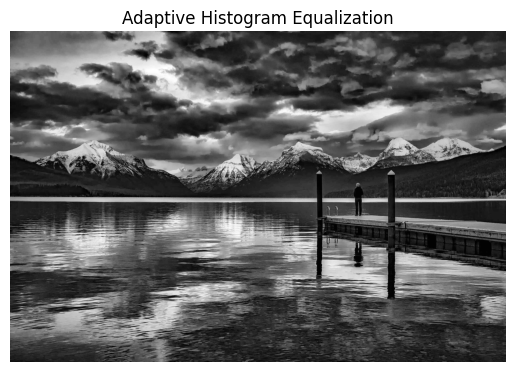

In [ ]:
import cupy as cp
import matplotlib.pyplot as plt
from skimage import exposure

def adaptive_histogram_equalization(image, clip_limit=0.01):
    # Perform AHE using skimage and convert to GPU array
    image_cpu = cp.asnumpy(image_cv)  # Convert CuPy array to NumPy for skimage
    ahe_image_cpu = exposure.equalize_adapthist(image_cpu, clip_limit=clip_limit)

    return cp.asarray(ahe_image_cpu)  # Convert back to CuPy array

# Load image (assuming you already have the image loaded)
# image = your image loading function
equalized_image_ahe = adaptive_histogram_equalization(image_cv)

# Display the AHE image
plt.imshow(cp.asnumpy(equalized_image_ahe), cmap='gray')
plt.title('Adaptive Histogram Equalization')
plt.axis('off')
plt.show()


## Contrast Limited Adaptive Histogram Equalization (CLAHE)

**Contrast Limited Adaptive Histogram Equalization (CLAHE):**

CLAHE improves upon AHE by limiting the contrast enhancement to avoid amplifying noise in homogeneous areas of the image.
CPU-based CLAHE calculates histograms for each region, applies contrast limitations, and adjusts pixel intensities sequentially, which can still be slow for large images.
GPU-based CLAHE leverages parallel computation to calculate multiple regions simultaneously, applies contrast limits, and processes the image much faster than the CPU, especially beneficial for large-scale, real-time image processing applications like medical imaging, video processing, or satellite imagery.

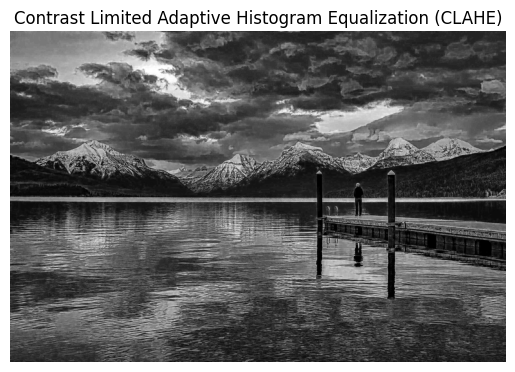

In [ ]:
import cupy as cp
import matplotlib.pyplot as plt
from skimage import exposure

def clahe(image, clip_limit=0.01, tile_grid_size=(8, 8)):
    # Perform CLAHE using skimage and convert to GPU array
    image_cpu = cp.asnumpy(image)  # Convert CuPy array to NumPy for skimage
    clahe = exposure.equalize_adapthist(image_cpu, clip_limit=clip_limit, nbins=256, kernel_size=tile_grid_size)

    return cp.asarray(clahe)  # Convert back to CuPy array

# Apply CLAHE to the image
equalized_image_clahe = clahe(image_cv)

# Display the CLAHE image
plt.imshow(cp.asnumpy(equalized_image_clahe), cmap='gray')
plt.title('Contrast Limited Adaptive Histogram Equalization (CLAHE)')
plt.axis('off')
plt.show()


 t

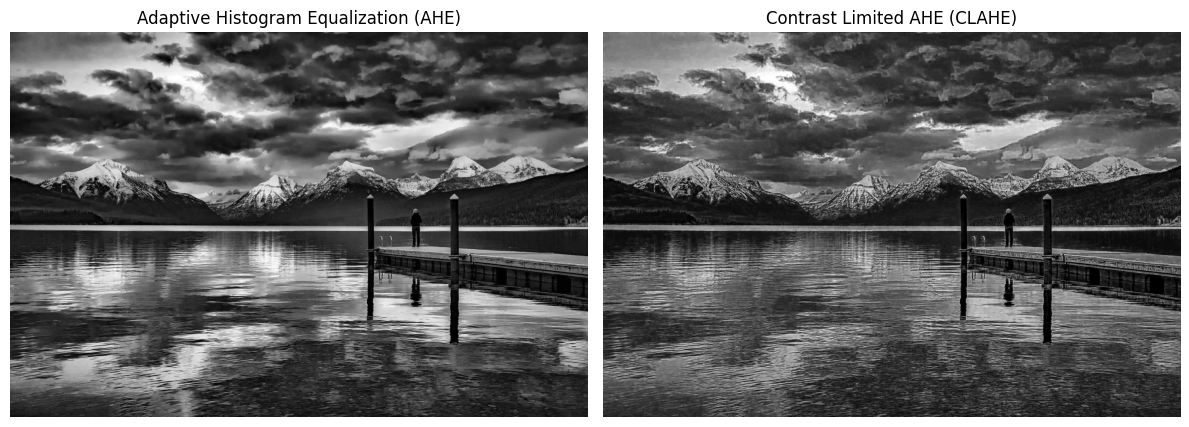